In [124]:
import time
import random
import numpy as np
import networkx as nx
import logging
from itertools import combinations
import matplotlib.pyplot as plt
from icecream import ic

===========================================================================================
### Definizione del Problema
===========================================================================================

In [125]:
class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        total_cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='dist'
        ).items():
            cost = 0
            for c1, c2 in zip(path, path[1:]):
                cost += self.cost([c1, c2], 0)
                cost += self.cost([c1, c2], self._graph.nodes[dest]['gold'])
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)} ({cost})"
            )
            total_cost += cost
        return total_cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)

In [ ]:
import numpy as np

def print_problem_stats(problem_instance):

    g = problem_instance.graph
    distances = [data['dist'] for u, v, data in g.edges(data=True)]
    if len(distances) > 0:
        avg_dist = np.mean(distances)
        min_dist = np.min(distances)
        max_dist = np.max(distances)
    else:
        avg_dist = 0.0
    weights = [data['gold'] for n, data in g.nodes(data=True)]
    
    if len(weights) > 0:
        avg_weight = np.mean(weights)
    else:
        avg_weight = 0.0

    print("-" * 30)
    print(f"📊 Statistiche Istanza Problema")
    print("-" * 30)
    print(f"Numero Città:      {g.number_of_nodes()}")
    print(f"Numero Archi:      {g.number_of_edges()}")
    print(f"Media Distanze:    {avg_dist:.4f}")
    print(f"Media Pesi (Gold): {avg_weight:.4f}")
    print("-" * 30)

In [127]:
problem = Problem(num_cities=100, alpha=1, beta=0.5, density=0.5, seed=42)
print_problem_stats(problem)

------------------------------
📊 Statistiche Istanza Problema
------------------------------
Numero Città:      100
Numero Archi:      2585
Media Distanze:    0.5084
Media Pesi (Gold): 466.3207
------------------------------


In [ ]:
def run_logistics_robot(problem, genome, dist_cache): 
    w1, w2, w3 = genome
    graph = problem.graph
    all_pairs_dist = dist_cache 
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    path = [0]
    total_cost = 0.0
    
    cities_with_gold = set(graph.nodes) - {0}
    
    while cities_with_gold:
        should_return_home = False
        
        if current_node != 0:
            dist_to_home = all_pairs_dist[current_node][0] 
            current_stress = (current_load * dist_to_home)
            if current_stress > w3:
                should_return_home = True
        
        target_node = None
        
        if should_return_home:
            target_node = 0
        else:
            candidates = []
            for node in cities_with_gold:
                dist = all_pairs_dist[current_node][node]
                gold = graph.nodes[node]['gold']
                norm_dist = dist / 1.414
                norm_gold = gold / 1000.0
                score = (norm_dist ** w1) * ((1.0 + norm_gold) ** w2)
                candidates.append((score, node))
            
            candidates.sort(key=lambda x: x[0])
            top_k = 3 
            if candidates:
                choice_idx = random.randint(0, min(len(candidates), top_k) - 1)
                target_node = candidates[choice_idx][1]
            else:
                target_node = None
                    
        if target_node is None: target_node = 0
        if target_node == current_node:
            if cities_with_gold: target_node = next(iter(cities_with_gold))
            else: break
        
        try:
            travel_path = nx.shortest_path(graph, source=current_node, target=target_node, weight='dist')
            for i in range(1, len(travel_path)):
                u = travel_path[i-1]
                v = travel_path[i]
            
                path.append(v)
                
                step_dist = all_pairs_dist[u][v]
                step_cost = step_dist + (alpha * step_dist * current_load) ** beta
                total_cost += step_cost
                
                if v == 0:
                    current_load = 0 
                elif v == target_node and v in cities_with_gold:
                    current_load += graph.nodes[v]['gold']
                    cities_with_gold.remove(v)
            
            current_node = target_node
            
        except nx.NetworkXNoPath:
            break

    if current_node != 0:
        travel_path = nx.shortest_path(graph, source=current_node, target=0, weight='dist')
        for i in range(1, len(travel_path)):
            u = travel_path[i-1]
            v = travel_path[i]
            path.append(v)
            step_dist = all_pairs_dist[u][v]
            step_cost = step_dist + (alpha * step_dist * current_load) ** beta
            total_cost += step_cost
            if v == 0: current_load = 0

    return path, total_cost

In [ ]:
def calculate_fitness(problem, path):
    total_cost = 0
    current_weight = 0
    
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i+1]
        
        segment_cost = problem.cost([u, v], current_weight)
        total_cost += segment_cost
        
        if v == 0:
            current_weight = 0 
        else:
            current_weight += problem.graph.nodes[v]['gold']
            
    return total_cost

In [ ]:
class GeneticOptimizer:
    def __init__(self, problem, pop_size=50, mutation_rate=0.2, sigma=0.5):
        self.problem = problem
        print("Calcolo cache distanze...")
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        print("Cache pronta!")
        
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.sigma = sigma
        self.population = []
        self.population.append(np.array([10.0, 0.0, 0.001]))
        self.population.append(np.array([3.0, 2.0, 1500.0]))
        for _ in range(30):
            self.population.append(np.array([np.random.uniform(0, 10), np.random.uniform(-5, 5), np.random.uniform(10, 1000)]))
        for _ in range(40):
            self.population.append(np.array([np.random.uniform(0, 10), np.random.uniform(-5, 5), np.random.uniform(1000, 5000)]))
        for _ in range(28):
            self.population.append(np.array([np.random.uniform(0, 10), np.random.uniform(-5, 5), np.random.uniform(5000, 20000)]))

    def evaluate_population(self):
        scores = []
        for genome in self.population:
            genome[0] = abs(genome[0])
            genome[2] = abs(genome[2])

            path, cost = run_logistics_robot(self.problem, genome, self.dist_cache)
            
            scores.append((cost, genome, path))
        
        scores.sort(key=lambda x: x[0])
        return scores
    
    def select_parent(self, sorted_population):
        tournament = random.sample(sorted_population, 3)
        tournament.sort(key=lambda x: x[0])
        return tournament[0][1]

    def crossover(self, p1, p2):
        alpha = np.random.random()
        child = alpha * p1 + (1 - alpha) * p2
        return child

    def mutate(self, genome):
        if np.random.random() < self.mutation_rate:
            noise = np.random.normal(0, self.sigma, size=3)
            scale = np.random.uniform(0.8, 1.2, size=3)
            if np.random.random() < 0.5:
                genome += noise
            else:
                genome *= scale
            genome[0] = abs(genome[0])
            genome[2] = abs(genome[2])
        return genome

    def evolve(self, generations=50):
        best_solution_ever = None
        best_cost_ever = float('inf')

        for gen in range(generations):
            scored_pop = self.evaluate_population()
            best_gen_cost, best_gen_genome, best_gen_path = scored_pop[0]
            avg_cost = np.mean([s[0] for s in scored_pop])
            
            genes_str = f"[w1={best_gen_genome[0]:.2f}, w2={best_gen_genome[1]:.2f}, w3={best_gen_genome[2]:.1f}]"

            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = (best_gen_genome, best_gen_path)
                print(f"Gen {gen}: 🟢 RECORD {best_cost_ever:.2f} | {genes_str}")
            else:
                if gen % 5 == 0:
                    print(f"Gen {gen}: Stallo ({best_gen_cost:.2f}) | Avg Pop: {avg_cost:.2f} | {genes_str}")

            new_pop = [scored_pop[0][1], scored_pop[1][1]]
            while len(new_pop) < self.pop_size:
                parent1 = self.select_parent(scored_pop)
                parent2 = self.select_parent(scored_pop)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            
        return best_solution_ever, best_cost_ever

GENETIC OPTIMIZER $\beta$ < 1

In [ ]:
import numpy as np
import networkx as nx
import random

def run_logistics_robot(problem, genome, dist_cache): 
    w1, w2 = genome 
    
    graph = problem.graph
    all_pairs_dist = dist_cache 
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    path = [0]
    total_cost = 0.0
    
    cities_with_gold = set(graph.nodes) - {0}
    
    while cities_with_gold:
        candidates = []
        for node in cities_with_gold:
            dist = all_pairs_dist[current_node][node]
            gold = graph.nodes[node]['gold']
            
            norm_dist = dist / 1.414
            norm_gold = gold / 1000.0
            
            score = (norm_dist ** w1) * ((1.0 + norm_gold) ** w2)
            candidates.append((score, node))
        
        candidates.sort(key=lambda x: x[0])
        
        top_k = 3 
        target_node = None
        if candidates:
            choice_idx = random.randint(0, min(len(candidates), top_k) - 1)
            target_node = candidates[choice_idx][1]
        
        if target_node is None: break

        dist_direct = all_pairs_dist[current_node][target_node]
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        dist_to_home = all_pairs_dist[current_node][0]
        cost_home_leg1 = dist_to_home + (alpha * dist_to_home * current_load) ** beta
        dist_from_home = all_pairs_dist[0][target_node]
        cost_home_leg2 = dist_from_home 
        
        cost_via_home = cost_home_leg1 + cost_home_leg2

        if current_node != 0 and cost_via_home < cost_direct:
            target_node = 0 

        if target_node == current_node:
             if cities_with_gold: target_node = next(iter(cities_with_gold))
             else: break

        try:
            travel_path = nx.shortest_path(graph, source=current_node, target=target_node, weight='dist')
            
            for i in range(1, len(travel_path)):
                u = travel_path[i-1]
                v = travel_path[i]
                
                path.append(v)

                step_dist = all_pairs_dist[u][v]
                step_cost = step_dist + (alpha * step_dist * current_load) ** beta
                total_cost += step_cost
                
                if v == 0:
                    current_load = 0 
                elif v == target_node and v in cities_with_gold:
                    current_load += graph.nodes[v]['gold']
                    cities_with_gold.remove(v)
            
            current_node = target_node
            
        except nx.NetworkXNoPath:
            break

    if current_node != 0:
        travel_path = nx.shortest_path(graph, source=current_node, target=0, weight='dist')
        for i in range(1, len(travel_path)):
            u = travel_path[i-1]
            v = travel_path[i]
            path.append(v)
            step_dist = all_pairs_dist[u][v]
            step_cost = step_dist + (alpha * step_dist * current_load) ** beta
            total_cost += step_cost
            if v == 0: current_load = 0

    return path, total_cost

class GeneticOptimizer:
    def __init__(self, problem, pop_size=50, mutation_rate=0.2, sigma=0.5):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.sigma = sigma
        self.population = []
        
        self.population.append(np.array([10.0, 0.0]))
        self.population.append(np.array([3.0, 2.0]))
        
        for _ in range(pop_size - 2):
            gene = np.array([
                np.random.uniform(0, 10),   # w1
                np.random.uniform(-5, 5)    # w2
            ])
            self.population.append(gene)

    def evaluate_population(self):
        scores = []
        for genome in self.population:
            genome[0] = abs(genome[0]) 
            path, cost = run_logistics_robot(self.problem, genome, self.dist_cache)
            scores.append((cost, genome, path))
        
        scores.sort(key=lambda x: x[0])
        return scores

    def select_parent(self, sorted_population):
        tournament = random.sample(sorted_population, 3)
        tournament.sort(key=lambda x: x[0])
        return tournament[0][1]

    def crossover(self, p1, p2):
        alpha = np.random.random()
        child = alpha * p1 + (1 - alpha) * p2
        return child

    def mutate(self, genome):
        if np.random.random() < self.mutation_rate:
            noise = np.random.normal(0, self.sigma, size=2) 
            scale = np.random.uniform(0.8, 1.2, size=2)
            if np.random.random() < 0.5:
                genome += noise
            else:
                genome *= scale
            genome[0] = abs(genome[0])
        return genome

    def evolve(self, generations=50):
        best_solution_ever = None
        best_cost_ever = float('inf')

        for gen in range(generations):
            scored_pop = self.evaluate_population()
            best_gen_cost, best_gen_genome, best_gen_path = scored_pop[0]
            
            genes_str = f"[w1={best_gen_genome[0]:.2f}, w2={best_gen_genome[1]:.2f}]" 

            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = (best_gen_genome, best_gen_path)
                print(f"Gen {gen}: RECORD {best_cost_ever:.2f} | {genes_str}")
            elif gen % 10 == 0:
                 print(f"Gen {gen}: Stallo ({best_gen_cost:.2f}) | {genes_str}")

            new_pop = [scored_pop[0][1], scored_pop[1][1]]
            while len(new_pop) < self.pop_size:
                parent1 = self.select_parent(scored_pop)
                parent2 = self.select_parent(scored_pop)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            
        return best_solution_ever, best_cost_ever

my_problem = Problem(num_cities=100, alpha=1.0, beta=0.5, density=0.2, seed=42)
baseline_cost = my_problem.baseline()
print(f"--- Costo Baseline: {baseline_cost:.2f} ---")

optimizer = GeneticOptimizer(my_problem, pop_size=80, mutation_rate=0.4, sigma=1.0)
(best_genome, best_path), best_cost = optimizer.evolve(generations=50)

print(f"\n--- RISULTATO FINALE ---\nCosto: {best_cost:.2f}")
print(f"Miglioramento: {((baseline_cost - best_cost) / baseline_cost) * 100:.2f}%")

--- Costo Baseline: 2231.05 ---
Gen 0: 🟢 RECORD 2457.69 | [w1=0.14, w2=4.95]
Gen 1: 🟢 RECORD 2337.05 | [w1=0.14, w2=4.95]
Gen 4: 🟢 RECORD 2285.22 | [w1=0.16, w2=4.78]
Gen 6: 🟢 RECORD 2284.66 | [w1=0.30, w2=3.49]
Gen 10: Stallo (2322.20) | [w1=0.12, w2=4.32]
Gen 20: Stallo (2330.99) | [w1=0.11, w2=4.31]
Gen 30: Stallo (2378.57) | [w1=0.10, w2=4.34]
Gen 39: 🟢 RECORD 2252.84 | [w1=0.22, w2=4.71]
Gen 40: Stallo (2305.17) | [w1=0.08, w2=4.83]

--- RISULTATO FINALE ---
Costo: 2252.84
Miglioramento: -0.98%


In [ ]:
import numpy as np
import networkx as nx
import random
import copy

def evaluate_permutation(problem, permutation, dist_cache):
    """
    Prende una lista ordinata di città (es: [5, 2, 99, ...]) e calcola il costo
    applicando la logica del 'Ritorno Intelligente' passo dopo passo.
    """
    graph = problem.graph
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    total_cost = 0.0
    
    final_path = [0]

    for target_node in permutation:
        
        dist_direct = dist_cache[current_node][target_node]
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        
        dist_to_home = dist_cache[current_node][0]
        cost_home_leg1 = dist_to_home + (alpha * dist_to_home * current_load) ** beta
        
        dist_from_home = dist_cache[0][target_node]
        cost_home_leg2 = dist_from_home 
        
        cost_via_home = cost_home_leg1 + cost_home_leg2

        if current_node != 0 and cost_via_home < cost_direct:
            travel_path = nx.shortest_path(graph, source=current_node, target=0, weight='dist')
            for i in range(1, len(travel_path)):
                u, v = travel_path[i-1], travel_path[i]
                final_path.append(v)
                step_dist = dist_cache[u][v]
                total_cost += step_dist + (alpha * step_dist * current_load) ** beta
        
            current_node = 0
            current_load = 0
            
        travel_path = nx.shortest_path(graph, source=current_node, target=target_node, weight='dist')
        for i in range(1, len(travel_path)):
            u, v = travel_path[i-1], travel_path[i]
            final_path.append(v)
            
            step_dist = dist_cache[u][v]
            total_cost += step_dist + (alpha * step_dist * current_load) ** beta
            
            if v == target_node:
                current_load += graph.nodes[v]['gold']
        
        current_node = target_node

    if current_node != 0:
        travel_path = nx.shortest_path(graph, source=current_node, target=0, weight='dist')
        for i in range(1, len(travel_path)):
            u, v = travel_path[i-1], travel_path[i]
            final_path.append(v)
            step_dist = dist_cache[u][v]
            total_cost += step_dist + (alpha * step_dist * current_load) ** beta
            
    return final_path, total_cost

class PermutationOptimizer:
    def __init__(self, problem, pop_size=100, mutation_rate=0.2):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        
        self.cities = list(problem.graph.nodes)
        if 0 in self.cities: self.cities.remove(0)
        
        greedy_genome = self._generate_greedy_genome()
        self.population.append(greedy_genome)
        
        for _ in range(pop_size - 1):
            perm = self.cities.copy()
            random.shuffle(perm)
            self.population.append(perm)

    def _generate_greedy_genome(self):
        unvisited = set(self.cities)
        current = 0
        path = []
        while unvisited:
            nearest = min(unvisited, key=lambda x: self.dist_cache[current][x])
            path.append(nearest)
            unvisited.remove(nearest)
            current = nearest
        return path

    def evaluate_population(self):
        scores = []
        for genome in self.population:
            path, cost = evaluate_permutation(self.problem, genome, self.dist_cache)
            scores.append((cost, genome, path)) 
        scores.sort(key=lambda x: x[0])
        return scores

    def crossover_ox1(self, parent1, parent2):
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        child = [None] * size
        child[start:end] = parent1[start:end]
        
        current_pos = end
        for gene in parent2:
            if gene not in child:
                if current_pos >= size:
                    current_pos = 0
                child[current_pos] = gene
                current_pos += 1
        return child

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(genome)), 2)
            genome[idx1], genome[idx2] = genome[idx2], genome[idx1]
        return genome

    def evolve(self, generations=50):
        best_solution_ever = None
        best_cost_ever = float('inf')

        for gen in range(generations):
            scored_pop = self.evaluate_population()
            best_gen_cost, best_gen_genome, best_gen_path = scored_pop[0]
            
            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = (best_gen_genome, best_gen_path)
                print(f"Gen {gen}: RECORD {best_cost_ever:.2f}")
            elif gen % 10 == 0:
                print(f"Gen {gen}: Stallo ({best_gen_cost:.2f})")

            new_pop = [scored_pop[0][1], scored_pop[1][1]] 
            
            while len(new_pop) < self.pop_size:
                p1 = random.choice(scored_pop[:50])[1] 
                p2 = random.choice(scored_pop[:50])[1]
                child = self.crossover_ox1(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            
            self.population = new_pop
            
        return best_solution_ever, best_cost_ever

my_problem = Problem(num_cities=100, alpha=1.0, beta=0.5, density=0.2, seed=42)
baseline_cost = my_problem.baseline()
print(f"--- Costo Baseline: {baseline_cost:.2f} ---")

optimizer = PermutationOptimizer(my_problem, pop_size=100, mutation_rate=0.3)
(best_genome, best_path), best_cost = optimizer.evolve(generations=100)

print(f"\n--- RISULTATO FINALE ---\nCosto: {best_cost:.2f}")
print(f"Miglioramento: {((baseline_cost - best_cost) / baseline_cost) * 100:.2f}%")

--- Costo Baseline: 2231.05 ---
Gen 0: 🟢 RECORD 2357.28
Gen 1: 🟢 RECORD 2351.03
Gen 2: 🟢 RECORD 2332.76
Gen 3: 🟢 RECORD 2281.48
Gen 4: 🟢 RECORD 2280.63
Gen 5: 🟢 RECORD 2276.13
Gen 6: 🟢 RECORD 2217.82
Gen 7: 🟢 RECORD 2185.63
Gen 10: 🟢 RECORD 2184.11
Gen 11: 🟢 RECORD 2164.40
Gen 16: 🟢 RECORD 2138.90
Gen 20: Stallo (2138.90)
Gen 24: 🟢 RECORD 2137.25
Gen 25: 🟢 RECORD 2130.49
Gen 29: 🟢 RECORD 2124.83
Gen 30: Stallo (2124.83)
Gen 32: 🟢 RECORD 2114.69
Gen 34: 🟢 RECORD 2105.80
Gen 35: 🟢 RECORD 2095.26
Gen 36: 🟢 RECORD 2089.67
Gen 38: 🟢 RECORD 2076.74
Gen 40: Stallo (2076.74)
Gen 41: 🟢 RECORD 2073.58
Gen 43: 🟢 RECORD 2067.70
Gen 46: 🟢 RECORD 2065.45
Gen 50: Stallo (2065.45)
Gen 51: 🟢 RECORD 2045.25
Gen 60: Stallo (2045.25)
Gen 61: 🟢 RECORD 2038.47
Gen 68: 🟢 RECORD 2036.62
Gen 69: 🟢 RECORD 2027.03
Gen 70: Stallo (2027.03)
Gen 73: 🟢 RECORD 2022.98
Gen 75: 🟢 RECORD 2022.90
Gen 77: 🟢 RECORD 1997.60
Gen 80: Stallo (1997.60)
Gen 81: 🟢 RECORD 1996.37
Gen 86: 🟢 RECORD 1996.32
Gen 90: Stallo (1996.32)
G

In [ ]:
import numpy as np
import networkx as nx
import random

def evaluate_permutation_smart(problem, permutation, dist_cache):
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    total_cost = 0.0
    
    reconstructed_path = [0] 
    
    for target_node in permutation:
        
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]

        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home
        
        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
            reconstructed_path.append(0) 
        else:
            total_cost += cost_direct
            
        current_load += problem.graph.nodes[target_node]['gold']
        current_node = target_node
        reconstructed_path.append(target_node)
    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    reconstructed_path.append(0)
    
    return reconstructed_path, total_cost

class GeneticOptimizer:
    def __init__(self, problem, pop_size=100, mutation_rate=0.2):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []

        self.cities = list(problem.graph.nodes)
        if 0 in self.cities: self.cities.remove(0)

        greedy_ind = self._create_greedy()
        self.population.append(greedy_ind)

        for _ in range(pop_size - 1):
            ind = self.cities.copy()
            random.shuffle(ind)
            self.population.append(ind)

    def _create_greedy(self):
        unvisited = set(self.cities)
        curr = 0
        path = []
        while unvisited:
            nxt = min(unvisited, key=lambda x: self.dist_cache[curr][x])
            path.append(nxt)
            unvisited.remove(nxt)
            curr = nxt
        return path

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            _, cost = evaluate_permutation_smart(self.problem, ind, self.dist_cache)
            scored.append((cost, ind))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=3):
        subset = random.sample(population, k)
        best = min(subset, key=lambda x: x[0])
        return best[1]

    def crossover(self, p1, p2):
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        
        current_pos = end
        for gene in p2:
            if gene not in child:
                if current_pos >= size: current_pos = 0
                child[current_pos] = gene
                current_pos += 1
        return child

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(genome)), 2)
            genome[i], genome[j] = genome[j], genome[i]
        return genome

    def evolve(self, generations=1000): 
        best_solution_ever = None
        best_cost_ever = float('inf')

        scored_pop = self.evaluate_population()
        
        for gen in range(generations):
            best_gen_cost, best_gen_genome = scored_pop[0]
            
            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = best_gen_genome[:] 
                full_path, _ = evaluate_permutation_smart(self.problem, best_gen_genome, self.dist_cache)
                print(f"Gen {gen}: NUOVO RECORD {best_cost_ever:.2f}")
            elif gen % 100 == 0:
                 print(f"Gen {gen}: ...lavorando... (Best: {best_cost_ever:.2f})")

            new_pop = [best_gen_genome] 
            
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            
            self.population = new_pop
            scored_pop = self.evaluate_population()
            
        return best_solution_ever, best_cost_ever

baseline_cost = my_problem.baseline()
print(f"--- Costo Baseline: {baseline_cost:.2f} ---")

optimizer = GeneticOptimizer(my_problem, pop_size=100, mutation_rate=0.3)

best_perm, best_cost = optimizer.evolve(generations=1000)

print(f"\n--- RISULTATO FINALE ---\nCosto GA: {best_cost:.2f}")
print(f"Miglioramento: {((baseline_cost - best_cost) / baseline_cost) * 100:.2f}%")

--- Costo Baseline: 2231.05 ---
Gen 0: 🚀 NUOVO RECORD 1676.39
Gen 4: 🚀 NUOVO RECORD 1674.05
Gen 5: 🚀 NUOVO RECORD 1633.56
Gen 6: 🚀 NUOVO RECORD 1633.27
Gen 8: 🚀 NUOVO RECORD 1630.04
Gen 10: 🚀 NUOVO RECORD 1626.33
Gen 11: 🚀 NUOVO RECORD 1616.62
Gen 12: 🚀 NUOVO RECORD 1609.43
Gen 13: 🚀 NUOVO RECORD 1603.48
Gen 14: 🚀 NUOVO RECORD 1591.13
Gen 16: 🚀 NUOVO RECORD 1584.43
Gen 17: 🚀 NUOVO RECORD 1576.92
Gen 19: 🚀 NUOVO RECORD 1575.92
Gen 21: 🚀 NUOVO RECORD 1570.05
Gen 26: 🚀 NUOVO RECORD 1569.92
Gen 32: 🚀 NUOVO RECORD 1562.73
Gen 37: 🚀 NUOVO RECORD 1561.50
Gen 38: 🚀 NUOVO RECORD 1561.21
Gen 39: 🚀 NUOVO RECORD 1560.00
Gen 43: 🚀 NUOVO RECORD 1560.00
Gen 44: 🚀 NUOVO RECORD 1556.90
Gen 46: 🚀 NUOVO RECORD 1554.00
Gen 47: 🚀 NUOVO RECORD 1550.82
Gen 48: 🚀 NUOVO RECORD 1550.23
Gen 49: 🚀 NUOVO RECORD 1548.60
Gen 50: 🚀 NUOVO RECORD 1548.25
Gen 51: 🚀 NUOVO RECORD 1547.70
Gen 52: 🚀 NUOVO RECORD 1546.81
Gen 54: 🚀 NUOVO RECORD 1545.53


KeyboardInterrupt: 

In [ ]:
import numpy as np
import networkx as nx
import random

def run_logistics_robot(problem, genome, dist_cache): 
    # w1: Peso Distanza (Selezione)
    # w2: Peso Oro (Selezione)
    # w3: FATTORE PRUDENZA (Rientro). 
    #     < 1.0 = Prudentissimo (Torna sempre) -> BASELINE
    #     > 1.0 = Temerario (Accumula) -> TSP
    w1, w2, w3 = genome 
    
    graph = problem.graph
    all_pairs_dist = dist_cache 
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    path = [0]
    total_cost = 0.0
    
    cities_with_gold = set(graph.nodes) - {0}
    
    while cities_with_gold:

        candidates = []
        for node in cities_with_gold:
            dist = all_pairs_dist[current_node][node]
            gold = graph.nodes[node]['gold']
            
            norm_dist = dist / 1.414
            norm_gold = gold / 1000.0
            
            score = (norm_dist ** w1) / ((1.0 + norm_gold) ** w2)
            candidates.append((score, node))
        
        candidates.sort(key=lambda x: x[0])
        
        top_k = 3 
        target_node = None
        if candidates:
            choice_idx = random.randint(0, min(len(candidates), top_k) - 1)
            target_node = candidates[choice_idx][1]
        
        if target_node is None: break

        dist_direct = all_pairs_dist[current_node][target_node]
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
    
        dist_to_home = all_pairs_dist[current_node][0]
        cost_home_leg1 = dist_to_home + (alpha * dist_to_home * current_load) ** beta
        dist_from_home = all_pairs_dist[0][target_node]
        cost_home_leg2 = dist_from_home 
        
        cost_via_home = cost_home_leg1 + cost_home_leg2
        
        bias = 1.0 / (w3 + 0.0001)
        
        if current_node != 0 and (cost_via_home < (cost_direct * bias)):
            target_node = 0 
            
        if target_node == current_node:
             if cities_with_gold: target_node = next(iter(cities_with_gold))
             else: break
        try:
            travel_path = nx.shortest_path(graph, source=current_node, target=target_node, weight='dist')
            for i in range(1, len(travel_path)):
                u, v = travel_path[i-1], travel_path[i]
                path.append(v)
                step_dist = all_pairs_dist[u][v]
                step_cost = step_dist + (alpha * step_dist * current_load) ** beta
                total_cost += step_cost
                if v == 0:
                    current_load = 0 
                elif v == target_node and v in cities_with_gold:
                    current_load += graph.nodes[v]['gold']
                    cities_with_gold.remove(v)
            current_node = target_node
        except nx.NetworkXNoPath:
            break

    if current_node != 0:
        travel_path = nx.shortest_path(graph, source=current_node, target=0, weight='dist')
        for i in range(1, len(travel_path)):
            u, v = travel_path[i-1], travel_path[i]
            path.append(v)
            step_dist = all_pairs_dist[u][v]
            step_cost = step_dist + (alpha * step_dist * current_load) ** beta
            total_cost += step_cost
            if v == 0: current_load = 0

    return path, total_cost

class GeneticOptimizer:
    def __init__(self, problem, pop_size=50, mutation_rate=0.2, sigma=0.5):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.sigma = sigma
        self.population = []

        self.population.append(np.array([5.0, 0.0, 0.01]))
        self.population.append(np.array([2.0, 2.0, 1.0]))
        self.population.append(np.array([1.0, 5.0, 2.0]))
        
        for _ in range(pop_size - 3):
            gene = np.array([
                np.random.uniform(0, 10),   # w1
                np.random.uniform(0, 10),   # w2
                np.random.uniform(0.1, 3.0) # w3 
            ])
            self.population.append(gene)

    def evaluate_population(self):
        scores = []
        for genome in self.population:
            genome = np.abs(genome)
            path, cost = run_logistics_robot(self.problem, genome, self.dist_cache)
            scores.append((cost, genome, path))
        scores.sort(key=lambda x: x[0])
        return scores

    def select_parent(self, sorted_population):
        tournament = random.sample(sorted_population, 3)
        tournament.sort(key=lambda x: x[0])
        return tournament[0][1]

    def crossover(self, p1, p2):
        alpha = np.random.random()
        child = alpha * p1 + (1 - alpha) * p2
        return child

    def mutate(self, genome):
        if np.random.random() < self.mutation_rate:
            noise = np.random.normal(0, self.sigma, size=3)
            scale = np.random.uniform(0.8, 1.2, size=3)
            if np.random.random() < 0.5:
                genome += noise
            else:
                genome *= scale
            genome = np.abs(genome)
        return genome

    def evolve(self, generations=50):
        best_solution_ever = None
        best_cost_ever = float('inf')

        for gen in range(generations):
            scored_pop = self.evaluate_population()
            best_gen_cost, best_gen_genome, best_gen_path = scored_pop[0]
            
            genes_str = f"[Dist={best_gen_genome[0]:.2f}, Gold={best_gen_genome[1]:.2f}, VogliaFuori={best_gen_genome[2]:.2f}]"

            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = (best_gen_genome, best_gen_path)
                print(f"Gen {gen}: RECORD {best_cost_ever:.2f} | {genes_str}")
            elif gen % 10 == 0:
                 print(f"Gen {gen}: Stallo ({best_gen_cost:.2f}) | {genes_str}")

            new_pop = [scored_pop[0][1], scored_pop[1][1]]
            while len(new_pop) < self.pop_size:
                p1 = self.select_parent(scored_pop)
                p2 = self.select_parent(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            
        return best_solution_ever, best_cost_ever

my_problem = Problem(num_cities=100, alpha=1.0, beta=1, density=1, seed=42)
baseline_cost = my_problem.baseline()
print(f"--- Costo Baseline: {baseline_cost:.2f} ---")

optimizer = GeneticOptimizer(my_problem, pop_size=100, mutation_rate=0.4, sigma=0.5)
(best_genome, best_path), best_cost = optimizer.evolve(generations=60)

print(f"\n--- RISULTATO FINALE ---\nCosto: {best_cost:.2f}")
print(f"Miglioramento: {((baseline_cost - best_cost) / baseline_cost) * 100:.2f}%")

--- Costo Baseline: 18266.19 ---
Gen 0: 🟢 RECORD 18266.19 | [Dist=5.00, Gold=0.00, VogliaFuori=0.01]
Gen 1: 🟢 RECORD 18266.17 | [Dist=5.00, Gold=0.00, VogliaFuori=0.01]
Gen 6: 🟢 RECORD 18266.17 | [Dist=5.36, Gold=0.72, VogliaFuori=0.02]
Gen 10: Stallo (18266.17) | [Dist=6.35, Gold=1.04, VogliaFuori=0.02]
Gen 20: Stallo (18266.17) | [Dist=4.98, Gold=0.91, VogliaFuori=0.02]
Gen 30: Stallo (18266.17) | [Dist=6.28, Gold=0.97, VogliaFuori=0.02]
Gen 40: Stallo (18266.17) | [Dist=7.30, Gold=0.89, VogliaFuori=0.02]
Gen 50: Stallo (18266.17) | [Dist=6.50, Gold=1.12, VogliaFuori=0.02]

--- RISULTATO FINALE ---
Costo: 18266.17
Miglioramento: 0.00%


In [ ]:
import numpy as np
import networkx as nx
import random

def evaluate_permutation_smart(problem, permutation, dist_cache, static_graph_gold):
    alpha = problem.alpha
    beta = problem.beta
    
    current_node = 0
    current_load = 0
    total_cost = 0.0
    reconstructed_path = [0] 
    
    for target_node in permutation:
        
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]
        
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home
        
        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
            reconstructed_path.append(0) 
        else:
            total_cost += cost_direct
            
        current_load += static_graph_gold[target_node]
        current_node = target_node
        reconstructed_path.append(target_node)

    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    reconstructed_path.append(0)
    
    return reconstructed_path, total_cost

class PermutationOptimizer:
    def __init__(self, problem, pop_size=100, mutation_rate=0.3):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')
        
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        
        self.cities = list(problem.graph.nodes)
        if 0 in self.cities: self.cities.remove(0)
        
        greedy_ind = self._create_greedy()
        self.population.append(greedy_ind)
        
        for _ in range(pop_size - 1):
            ind = self.cities.copy()
            random.shuffle(ind)
            self.population.append(ind)

    def _create_greedy(self):
        unvisited = set(self.cities)
        curr = 0
        path = []
        while unvisited:
            nxt = min(unvisited, key=lambda x: self.dist_cache[curr][x])
            path.append(nxt)
            unvisited.remove(nxt)
            curr = nxt
        return path

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            _, cost = evaluate_permutation_smart(self.problem, ind, self.dist_cache, self.static_gold)
            scored.append((cost, ind))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=4): 
        subset = random.sample(population, k)
        best = min(subset, key=lambda x: x[0])
        return best[1]

    def crossover(self, p1, p2):
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        
        current_pos = end
        for gene in p2:
            if gene not in child:
                if current_pos >= size: current_pos = 0
                child[current_pos] = gene
                current_pos += 1
        return child

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(genome)), 2)
            genome[i], genome[j] = genome[j], genome[i]
        return genome

    def evolve(self, generations=1000):
        best_solution_ever = None
        best_cost_ever = float('inf')

        scored_pop = self.evaluate_population()
        
        for gen in range(generations):
            best_gen_cost, best_gen_genome = scored_pop[0]
            
            if best_gen_cost < best_cost_ever:
                best_cost_ever = best_gen_cost
                best_solution_ever = best_gen_genome[:] 
                print(f"Gen {gen}: RECORD {best_cost_ever:.2f}")
            elif gen % 50 == 0:
                 print(f"Gen {gen}: ...lavorando... (Best: {best_cost_ever:.2f})")

            new_pop = [best_gen_genome] 
            
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            
            self.population = new_pop
            scored_pop = self.evaluate_population()
            
        full_path, final_cost = evaluate_permutation_smart(self.problem, best_solution_ever, self.dist_cache, self.static_gold)
        return full_path, final_cost

my_problem = Problem(num_cities=100, alpha=1.0, beta=1, density=1, seed=42)
baseline_cost = my_problem.baseline()
print(f"--- Costo Baseline: {baseline_cost:.2f} ---")

optimizer = PermutationOptimizer(my_problem, pop_size=150, mutation_rate=0.35)

best_path, best_cost = optimizer.evolve(generations=1000)

print(f"\n--- RISULTATO FINALE ---\nCosto GA: {best_cost:.2f}")
print(f"Miglioramento: {((baseline_cost - best_cost) / baseline_cost) * 100:.2f}%")

--- Costo Baseline: 18266.19 ---
Pre-calcolo cache distanze e oro...
Gen 0: 🚀 RECORD 19525.42
Gen 1: 🚀 RECORD 19247.36
Gen 2: 🚀 RECORD 19150.07
Gen 3: 🚀 RECORD 18860.49
Gen 4: 🚀 RECORD 18852.21
Gen 5: 🚀 RECORD 18828.31
Gen 6: 🚀 RECORD 18704.59
Gen 8: 🚀 RECORD 18590.66
Gen 9: 🚀 RECORD 18585.07
Gen 12: 🚀 RECORD 18542.79
Gen 14: 🚀 RECORD 18381.47
Gen 17: 🚀 RECORD 18381.47
Gen 20: 🚀 RECORD 18332.76
Gen 23: 🚀 RECORD 18320.36
Gen 25: 🚀 RECORD 18320.36
Gen 26: 🚀 RECORD 18300.58
Gen 32: 🚀 RECORD 18299.34
Gen 37: 🚀 RECORD 18287.20
Gen 38: 🚀 RECORD 18284.05
Gen 43: 🚀 RECORD 18281.35
Gen 46: 🚀 RECORD 18277.48
Gen 49: 🚀 RECORD 18272.38
Gen 50: ...lavorando... (Best: 18272.38)
Gen 64: 🚀 RECORD 18271.62
Gen 77: 🚀 RECORD 18270.28
Gen 89: 🚀 RECORD 18270.14
Gen 100: ...lavorando... (Best: 18270.14)
Gen 110: 🚀 RECORD 18270.14
Gen 111: 🚀 RECORD 18269.90
Gen 112: 🚀 RECORD 18268.69
Gen 116: 🚀 RECORD 18267.29
Gen 135: 🚀 RECORD 18267.26
Gen 136: 🚀 RECORD 18267.26
Gen 150: ...lavorando... (Best: 18267.26)
Gen

In [ ]:
import numpy as np
import networkx as nx
import random
import time
from itertools import combinations


class Problem:
    def __init__(self, num_cities, alpha=1.0, beta=0.5, density=0.5, seed=42):
        self._alpha = alpha
        self._beta = beta
        rng = np.random.default_rng(seed)
        
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5 
        
        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))
            
        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

    @property
    def graph(self):
        return self._graph

class HillClimbingOptimizer:
    def __init__(self, problem):
        self.problem = problem
        self.dist_matrix = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.gold_map = nx.get_node_attributes(problem.graph, 'gold')
        self.alpha = problem._alpha
        self.beta = problem._beta

    def get_initial_solution(self):
        cities = list(self.problem.graph.nodes)
        cities.remove(0)
        random.shuffle(cities)
        
        solution = [0]
        for c in cities:
            solution.append(c)
            solution.append(0)
        return solution

    def evaluate(self, solution):

        total_cost = 0.0
        current_load = 0.0
        
        for i in range(len(solution) - 1):
            u = solution[i]
            v = solution[i+1]
            
            dist = self.dist_matrix[u][v]
            step_cost = dist + (self.alpha * dist * current_load) ** self.beta
            total_cost += step_cost
            
            if v == 0:
                current_load = 0 
            else:
                current_load += self.gold_map[v]
                
        return total_cost

    def mutation_lv1_remove_zero(self, sol):
        """Rimuove uno zero interno per unire due viaggi."""
        zeros_indices = [i for i, x in enumerate(sol) if x == 0 and i != 0 and i != len(sol)-1]
        if not zeros_indices: return sol
        
        idx = random.choice(zeros_indices)
        new_sol = sol[:idx] + sol[idx+1:]
        return new_sol

    def mutation_lv1_swap_segments(self, sol):
        segments = []
        current_seg = []
        for node in sol[1:]: 
            if node == 0:
                if current_seg: segments.append(current_seg)
                current_seg = []
            else:
                current_seg.append(node)
        
        if len(segments) < 2: return sol

        i, j = random.sample(range(len(segments)), 2)
        segments[i], segments[j] = segments[j], segments[i]

        new_sol = [0]
        for seg in segments:
            new_sol.extend(seg)
            new_sol.append(0)
        return new_sol

    def mutation_lv2_add_zero_smart(self, sol):
        candidates = []
        for i in range(1, len(sol)-1):
            node = sol[i]
            if node != 0 and sol[i+1] != 0:
                dist_to_zero = self.dist_matrix[node][0]
                candidates.append((i, dist_to_zero))
        
        if not candidates: return sol
        candidates.sort(key=lambda x: x[1])
        top_k = max(1, len(candidates)//4) 
        idx, _ = random.choice(candidates[:top_k])

        new_sol = sol[:idx+1] + [0] + sol[idx+1:]
        return new_sol

    def mutation_lv3_swap_nodes(self, sol):
        city_indices = [i for i, x in enumerate(sol) if x != 0]
        if len(city_indices) < 2: return sol
        
        i, j = random.sample(city_indices, 2)
        new_sol = sol[:]
        new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
        return new_sol

    def run(self, max_iter=2000):
        current_sol = self.get_initial_solution()
        current_cost = self.evaluate(current_sol)
        
        best_sol = current_sol[:]
        best_cost = current_cost
        
        stagnation = 0
        
        print(f"Start Cost (Baseline): {current_cost:.2f}")
        
        for it in range(max_iter):
            new_sol = []
            strategy_name = ""
            
            r = random.random()
            
            if stagnation <= 5:
                if r < 0.5:
                    new_sol = self.mutation_lv1_remove_zero(current_sol)
                    strategy_name = "LV1_RemoveZero"
                else:
                    new_sol = self.mutation_lv1_swap_segments(current_sol)
                    strategy_name = "LV1_SwapSeg"

            elif 6 <= stagnation <= 10:
                if r < 0.5:
                    new_sol = self.mutation_lv2_add_zero_smart(current_sol)
                    strategy_name = "LV2_AddZeroSmart"
                else:
                    if random.random() < 0.5:
                        new_sol = self.mutation_lv1_remove_zero(current_sol)
                        strategy_name = "LV2->LV1_Rem"
                    else:
                        new_sol = self.mutation_lv1_swap_segments(current_sol)
                        strategy_name = "LV2->LV1_Swap"

            else:
                if r < 0.2:
                    new_sol = self.mutation_lv3_swap_nodes(current_sol)
                    strategy_name = "LV3_SwapNodes"
                elif r < 0.6: 
                    if random.random() < 0.5:
                        new_sol = self.mutation_lv1_remove_zero(current_sol)
                        strategy_name = "LV3->LV1"
                    else:
                        new_sol = self.mutation_lv1_swap_segments(current_sol)
                        strategy_name = "LV3->LV1"
                else: 
                     new_sol = self.mutation_lv2_add_zero_smart(current_sol)
                     strategy_name = "LV3->LV2"

            new_cost = self.evaluate(new_sol)
            if new_cost < current_cost:
                diff = current_cost - new_cost
                current_cost = new_cost
                current_sol = new_sol
                stagnation = 0 
                print(f"Iter {it}: Improved ({strategy_name}) -> {current_cost:.2f} (-{diff:.2f})")
                
                if current_cost < best_cost:
                    best_cost = current_cost
                    best_sol = current_sol[:]
            else:
                stagnation += 1

        return best_sol, best_cost


p = Problem(num_cities=100, alpha=1, beta=1, density=0.2, seed=42)

climber = HillClimbingOptimizer(p)
start_t = time.time()
best_path, best_cost = climber.run(max_iter=1000000000) 
end_t = time.time()

print(f"\n--- RISULTATO FINALE HILL CLIMBER ---")
print(f"Costo: {best_cost:.2f}")
print(f"Tempo: {end_t - start_t:.2f}s")

Pre-calcolo matrici...
Start Cost (Baseline): 25266.41
Iter 18: 🟢 Improved (LV3->LV1) -> 25266.41 (-0.00)
Iter 22: 🟢 Improved (LV1_SwapSeg) -> 25266.41 (-0.00)
Iter 24: 🟢 Improved (LV1_SwapSeg) -> 25266.41 (-0.00)
Iter 42: 🟢 Improved (LV3->LV1) -> 25266.41 (-0.00)
Iter 56: 🟢 Improved (LV3->LV1) -> 25266.41 (-0.00)
Iter 61: 🟢 Improved (LV1_SwapSeg) -> 25266.41 (-0.00)
Iter 193: 🟢 Improved (LV3_SwapNodes) -> 25266.41 (-0.00)
Iter 232: 🟢 Improved (LV3_SwapNodes) -> 25266.41 (-0.00)
Iter 297: 🟢 Improved (LV3_SwapNodes) -> 25266.41 (-0.00)
Iter 437: 🟢 Improved (LV3->LV1) -> 25266.41 (-0.00)
Iter 442: 🟢 Improved (LV1_RemoveZero) -> 25265.86 (-0.55)
Iter 474: 🟢 Improved (LV3->LV1) -> 25265.86 (-0.00)
Iter 500: 🟢 Improved (LV3->LV1) -> 25265.86 (-0.00)
Iter 525: 🟢 Improved (LV3_SwapNodes) -> 25265.86 (-0.00)
Iter 1015: 🟢 Improved (LV3->LV1) -> 25265.86 (-0.00)
Iter 1428: 🟢 Improved (LV3_SwapNodes) -> 25265.86 (-0.00)
Iter 1705: 🟢 Improved (LV3->LV1) -> 25265.86 (-0.00)
Iter 3649: 🟢 Improved (L

KeyboardInterrupt: 

In [ ]:
import numpy as np
import networkx as nx
import random
import time
from itertools import combinations

class Problem:
    def __init__(self, num_cities, alpha=1.0, beta=0.5, density=0.5, seed=42):
        self._alpha = alpha
        self._beta = beta
        rng = np.random.default_rng(seed)
        
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5
        
        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))
            
        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

    @property
    def graph(self):
        return self._graph
    
    @property
    def alpha(self):
        return self._alpha
        
    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        total_cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='dist'
        ).items():
            cost = 0
            for c1, c2 in zip(path, path[1:]):
                cost += self.cost([c1, c2], 0)
                cost += self.cost([c1, c2], self._graph.nodes[dest]['gold'])
            total_cost += cost
        return total_cost

class HillClimbingCollector:
    def __init__(self, problem):
        self.problem = problem
        self.dist_matrix = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.gold_map = nx.get_node_attributes(problem.graph, 'gold')
        self.alpha = problem._alpha
        self.beta = problem._beta

    def get_initial_solution(self):
        cities = list(self.problem.graph.nodes)
        cities.remove(0)
        random.shuffle(cities)
        solution = [0]
        for c in cities:
            solution.append(c)
            solution.append(0)
        return solution

    def evaluate(self, solution):
        total_cost = 0.0
        current_load = 0.0
        for i in range(len(solution) - 1):
            u = solution[i]
            v = solution[i+1]
            dist = self.dist_matrix[u][v]
            step_cost = dist + (self.alpha * dist * current_load) ** self.beta
            total_cost += step_cost
            if v == 0: current_load = 0
            else: current_load += self.gold_map[v]
        return total_cost

    def mutation_remove_zero(self, sol):
        zeros = [i for i, x in enumerate(sol) if x == 0 and i != 0 and i != len(sol)-1]
        if not zeros: return sol
        idx = random.choice(zeros)
        return sol[:idx] + sol[idx+1:]

    def mutation_swap_segments(self, sol):
        segments = []
        curr = []
        for node in sol[1:]:
            if node == 0:
                if curr: segments.append(curr)
                curr = []
            else: curr.append(node)
        if len(segments) < 2: return sol
        i, j = random.sample(range(len(segments)), 2)
        segments[i], segments[j] = segments[j], segments[i]
        new_sol = [0]
        for s in segments: new_sol.extend(s + [0])
        return new_sol

    def run_collect(self, max_iter=1000):
        current_sol = self.get_initial_solution()
        current_cost = self.evaluate(current_sol)
        
        def extract(path): return [x for x in path if x != 0]
        
        history = [extract(current_sol)]
        stagnation = 0
        
        for _ in range(max_iter):
            if stagnation < 5:
                if random.random() < 0.5: new_sol = self.mutation_remove_zero(current_sol)
                else: new_sol = self.mutation_swap_segments(current_sol)
            else:
                new_sol = self.mutation_swap_segments(current_sol)

            new_cost = self.evaluate(new_sol)
            
            if new_cost < current_cost:
                current_cost = new_cost
                current_sol = new_sol
                stagnation = 0
                history.append(extract(current_sol))
            else:
                stagnation += 1
                if random.random() < 0.05:
                    history.append(extract(new_sol))
                    
        return history


# GA
def evaluate_permutation_smart(problem, permutation, dist_cache, static_graph_gold):
    alpha = problem.alpha
    beta = problem.beta
    current_node = 0
    current_load = 0
    total_cost = 0.0
    
    for target_node in permutation:
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]
        
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home
        
        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
        else:
            total_cost += cost_direct
            
        current_load += static_graph_gold[target_node]
        current_node = target_node

    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    return total_cost

class PermutationOptimizer:
    def __init__(self, problem, initial_population=None, pop_size=100, mutation_rate=0.3):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        
        self.cities = list(problem.graph.nodes)
        if 0 in self.cities: self.cities.remove(0)
        
        if initial_population:
            print(f"Iniezione di {len(initial_population)} cromosomi dal Hill Climbing...")
            for ind in initial_population:
                if len(self.population) < pop_size:
                    self.population.append(ind)
    
        while len(self.population) < pop_size:
            ind = self.cities.copy()
            random.shuffle(ind)
            self.population.append(ind)

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            cost = evaluate_permutation_smart(self.problem, ind, self.dist_cache, self.static_gold)
            scored.append((cost, ind))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=3):
        subset = random.sample(population, k)
        best = min(subset, key=lambda x: x[0])
        return best[1]

    def crossover(self, p1, p2):
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        current_pos = end
        for gene in p2:
            if gene not in child:
                if current_pos >= size: current_pos = 0
                child[current_pos] = gene
                current_pos += 1
        return child

    def inversion_mutation(self, genome):
        size = len(genome)
        i, j = sorted(random.sample(range(size), 2))
        genome[i:j+1] = genome[i:j+1][::-1]
        return genome

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            if random.random() < 0.7:
                return self.inversion_mutation(genome)
            else:
                i, j = random.sample(range(len(genome)), 2)
                genome[i], genome[j] = genome[j], genome[i]
        return genome

    def evolve(self, generations=50):
        best_cost_ever = float('inf')
        scored_pop = self.evaluate_population()
    
        best_gen_cost, best_gen_genome = scored_pop[0]
        best_cost_ever = best_gen_cost
        
        for gen in range(generations):
            current_best_cost, current_best_genome = scored_pop[0]
            if current_best_cost < best_cost_ever:
                best_cost_ever = current_best_cost
                best_gen_genome = list(current_best_genome)
                print(f"GA Gen {gen}: RECORD {best_cost_ever:.2f}")

            new_pop = [list(best_gen_genome)] 
            
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            
            self.population = new_pop
            scored_pop = self.evaluate_population()
            
        return best_cost_ever


p = Problem(num_cities=100, alpha=1, beta=0.5, density=0.2, seed=42)
baseline = p.baseline()
print(f"--- Costo Baseline: {baseline:.2f} ---")

print("\n[FASE 1] Hill Climbing Exploration...")
climber = HillClimbingCollector(p)
history = climber.run_collect(max_iter=50000)

unique_seeds = []
seen = set()
for h in history:
    t = tuple(h)
    if t not in seen:
        seen.add(t)
        unique_seeds.append(h)
print(f"Trovate {len(unique_seeds)} soluzioni uniche.")

print("Valutazione semi per ranking...")
ranked_seeds = []

dist_cache = climber.dist_matrix
gold_map = climber.gold_map

for seed in unique_seeds:
    cost = evaluate_permutation_smart(p, seed, dist_cache, gold_map)
    ranked_seeds.append((cost, seed))

ranked_seeds.sort(key=lambda x: x[0])

best_seeds = [s for c, s in ranked_seeds[:80]]
print(f"Miglior seme HC: {ranked_seeds[0][0]:.2f}")


print(f"\n[FASE 2] Genetic Algorithm (Seed: {len(best_seeds)} Top Quality)")
ga = PermutationOptimizer(p, initial_population=best_seeds, pop_size=300, mutation_rate=0.35)

final_cost = ga.evolve(generations=5000)

print(f"\n--- RISULTATO IBRIDO FINALE ---")
print(f"Costo: {final_cost:.2f}")
print(f"Miglioramento: {((baseline - final_cost) / baseline) * 100:.2f}%")

--- Costo Baseline: 2231.05 ---

[FASE 1] Hill Climbing Exploration...
Trovate 2020 soluzioni uniche.
Valutazione semi per ranking...
Miglior seme HC: 1813.77

[FASE 2] Genetic Algorithm (Seed: 80 Top Quality)
Iniezione di 80 cromosomi dal Hill Climbing...
GA Gen 1: 🚀 RECORD 1683.07
GA Gen 2: 🚀 RECORD 1676.48
GA Gen 3: 🚀 RECORD 1666.86
GA Gen 4: 🚀 RECORD 1653.39
GA Gen 7: 🚀 RECORD 1625.41
GA Gen 9: 🚀 RECORD 1623.12
GA Gen 10: 🚀 RECORD 1613.46
GA Gen 18: 🚀 RECORD 1606.00
GA Gen 21: 🚀 RECORD 1604.80
GA Gen 23: 🚀 RECORD 1598.86
GA Gen 27: 🚀 RECORD 1593.81
GA Gen 30: 🚀 RECORD 1593.48
GA Gen 31: 🚀 RECORD 1591.30
GA Gen 32: 🚀 RECORD 1583.05
GA Gen 55: 🚀 RECORD 1580.95
GA Gen 56: 🚀 RECORD 1570.40
GA Gen 58: 🚀 RECORD 1570.40
GA Gen 59: 🚀 RECORD 1569.37
GA Gen 69: 🚀 RECORD 1565.14
GA Gen 71: 🚀 RECORD 1558.77
GA Gen 108: 🚀 RECORD 1558.30
GA Gen 117: 🚀 RECORD 1549.73
GA Gen 145: 🚀 RECORD 1546.91
GA Gen 165: 🚀 RECORD 1546.24
GA Gen 167: 🚀 RECORD 1543.38
GA Gen 186: 🚀 RECORD 1543.28
GA Gen 187: 🚀 R

In [ ]:
import numpy as np
import networkx as nx
import random
import time
from itertools import combinations

class Problem:
    def __init__(self, num_cities, alpha=1.0, beta=0.5, density=0.5, seed=42):
        self._alpha = alpha
        self._beta = beta
        rng = np.random.default_rng(seed)
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5
        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))
        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

    @property
    def graph(self): return self._graph
    @property
    def alpha(self): return self._alpha
    @property
    def beta(self): return self._beta
    
    def baseline(self):
        total = 0
        dist_matrix = dict(nx.all_pairs_dijkstra_path_length(self._graph, weight='dist'))
        for c in self._graph.nodes:
            if c != 0:
                d = dist_matrix[0][c]
                gold = self._graph.nodes[c]['gold']
                cost = d + (d + (self._alpha * d * gold) ** self._beta)
                total += cost
        return total

class HillClimbingRefiner:
    def __init__(self, problem):
        self.problem = problem
        self.dist_matrix = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.gold_map = nx.get_node_attributes(problem.graph, 'gold')
        self.alpha = problem._alpha
        self.beta = problem._beta

    def evaluate(self, solution):
        total_cost = 0.0
        current_load = 0.0
        for i in range(len(solution) - 1):
            u = solution[i]
            v = solution[i+1]
            dist = self.dist_matrix[u][v]
            step_cost = dist + (self.alpha * dist * current_load) ** self.beta
            total_cost += step_cost
            if v == 0: current_load = 0
            else: current_load += self.gold_map[v]
        return total_cost

    def mutation_swap_segments(self, sol):
        segments = []
        curr = []
        for node in sol[1:]:
            if node == 0:
                if curr: segments.append(curr)
                curr = []
            else: curr.append(node)
        if len(segments) < 2: return sol
        i, j = random.sample(range(len(segments)), 2)
        segments[i], segments[j] = segments[j], segments[i]
        new_sol = [0]
        for s in segments: new_sol.extend(s + [0])
        return new_sol

    def mutation_remove_zero(self, sol):
        zeros = [i for i, x in enumerate(sol) if x == 0 and i != 0 and i != len(sol)-1]
        if not zeros: return sol
        idx = random.choice(zeros)
        return sol[:idx] + sol[idx+1:]

    def run(self, initial_solution, max_iter=2000):
        """Prende una soluzione esistente e prova a lucidarla"""
        current_sol = initial_solution[:]
        current_cost = self.evaluate(current_sol)
        
        stagnation = 0
        for _ in range(max_iter):
            if random.random() < 0.5:
                new_sol = self.mutation_remove_zero(current_sol)
            else:
                new_sol = self.mutation_swap_segments(current_sol)
            
            new_cost = self.evaluate(new_sol)
            
            if new_cost < current_cost: 
                current_cost = new_cost
                current_sol = new_sol
                stagnation = 0
            else:
                stagnation += 1
                if stagnation > 200: break 
                
        return current_sol, current_cost

def evaluate_permutation_smart(problem, permutation, dist_cache, static_graph_gold):
    alpha = problem.alpha
    beta = problem.beta
    current_node = 0
    current_load = 0
    total_cost = 0.0
    
    reconstructed_path = [0] 
    
    for target_node in permutation:
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]
        
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home
        
        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
            reconstructed_path.append(0)
        else:
            total_cost += cost_direct
            
        current_load += static_graph_gold[target_node]
        current_node = target_node
        reconstructed_path.append(target_node)

    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    reconstructed_path.append(0)
    
    return total_cost, reconstructed_path

class PermutationOptimizer:
    def __init__(self, problem, initial_population=None, pop_size=100, mutation_rate=0.3):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        self.cities = list(problem.graph.nodes); 
        if 0 in self.cities: self.cities.remove(0)
        
        if initial_population:
            for ind in initial_population:
                if len(self.population) < pop_size: self.population.append(ind)
        while len(self.population) < pop_size:
            ind = self.cities.copy(); random.shuffle(ind); self.population.append(ind)

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            cost, path = evaluate_permutation_smart(self.problem, ind, self.dist_cache, self.static_gold)
            scored.append((cost, ind, path))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=3):
        return min(random.sample(population, k), key=lambda x: x[0])[1]

    def crossover(self, p1, p2): # OX1
        size = len(p1); start, end = sorted(random.sample(range(size), 2))
        child = [None]*size; child[start:end] = p1[start:end]
        curr = end
        for gene in p2:
            if gene not in child:
                if curr >= size: curr = 0
                child[curr] = gene; curr += 1
        return child

    def inversion_mutation(self, genome): # 2-opt
        i, j = sorted(random.sample(range(len(genome)), 2))
        genome[i:j+1] = genome[i:j+1][::-1]
        return genome

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            if random.random() < 0.7: return self.inversion_mutation(genome)
            else:
                i, j = random.sample(range(len(genome)), 2)
                genome[i], genome[j] = genome[j], genome[i]
        return genome

    def evolve(self, generations=50):
        scored_pop = self.evaluate_population()
        best_cost = scored_pop[0][0]
        
        for _ in range(generations):
            new_pop = [scored_pop[0][1]] 
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            scored_pop = self.evaluate_population()
            if scored_pop[0][0] < best_cost: best_cost = scored_pop[0][0]
            
        return scored_pop[0]

p = Problem(num_cities=100, alpha=1, beta=1, density=0.2, seed=42)
print(f"Baseline: {p.baseline():.2f}")

ga = PermutationOptimizer(p, pop_size=150, mutation_rate=0.4)
hc = HillClimbingRefiner(p)

best_global_cost = float('inf')
best_global_path = []
current_seeds = [] 

NUM_CYCLES = 10 
GA_GENS = 200  
HC_ITER = 5000 

print("\n--- AVVIO CICLO IBRIDO RICORSIVO ---")

for cycle in range(1, NUM_CYCLES + 1):
    print(f"\n🌀 CICLO {cycle}/{NUM_CYCLES}")
 
    if current_seeds:
        print(f"  > Re-seeding GA con {len(current_seeds)} soluzioni raffinate...")
        ga = PermutationOptimizer(p, initial_population=current_seeds, pop_size=150, mutation_rate=0.4)
    
    print(f"  > GA Evolving ({GA_GENS} gen)...")
    ga_result = ga.evolve(generations=GA_GENS)
    cost_ga, genome_ga, path_with_zeros_ga = ga_result
    print(f"    Result GA: {cost_ga:.2f}")
    print(f"  > HC Polishing...")
    refined_path, refined_cost = hc.run(path_with_zeros_ga, max_iter=HC_ITER)
    print(f"    Result HC: {refined_cost:.2f} (Miglioramento: {cost_ga - refined_cost:.2f})")
    
    if refined_cost < best_global_cost:
        best_global_cost = refined_cost
        best_global_path = refined_path
        print(f"NUOVO RECORD GLOBALE: {best_global_cost:.2f}")

    refined_perm = [x for x in refined_path if x != 0]

    current_seeds = [refined_perm]
    for _ in range(20):
        mutant = refined_perm[:]
        if random.random() < 0.5:
            i, j = random.sample(range(len(mutant)), 2)
            mutant[i], mutant[j] = mutant[j], mutant[i]
        else:
            i, j = sorted(random.sample(range(len(mutant)), 2))
            mutant[i:j+1] = mutant[i:j+1][::-1]
        current_seeds.append(mutant)

print(f"\n🏆 RISULTATO FINALE DOPO {NUM_CYCLES} CICLI: {best_global_cost:.2f}")
print(f"Miglioramento vs Baseline: {((p.baseline() - best_global_cost) / p.baseline()) * 100:.2f}%")

Baseline: 25266.41

--- AVVIO CICLO IBRIDO RICORSIVO ---

🌀 CICLO 1/10
  > GA Evolving (200 gen)...
    Result GA: 25487.15
  > HC Polishing...
    Result HC: 25486.63 (Miglioramento: 0.52)
🚀 NUOVO RECORD GLOBALE: 25486.63

🌀 CICLO 2/10
  > Re-seeding GA con 21 soluzioni raffinate...
  > GA Evolving (200 gen)...
    Result GA: 25316.01
  > HC Polishing...
    Result HC: 25316.01 (Miglioramento: 0.00)
🚀 NUOVO RECORD GLOBALE: 25316.01

🌀 CICLO 3/10
  > Re-seeding GA con 21 soluzioni raffinate...
  > GA Evolving (200 gen)...
    Result GA: 25367.76
  > HC Polishing...
    Result HC: 25367.76 (Miglioramento: 0.00)

🌀 CICLO 4/10
  > Re-seeding GA con 21 soluzioni raffinate...
  > GA Evolving (200 gen)...
    Result GA: 25370.47
  > HC Polishing...
    Result HC: 25370.47 (Miglioramento: 0.00)

🌀 CICLO 5/10
  > Re-seeding GA con 21 soluzioni raffinate...
  > GA Evolving (200 gen)...
    Result GA: 25403.39
  > HC Polishing...
    Result HC: 25403.39 (Miglioramento: 0.00)

🌀 CICLO 6/10
  > Re

In [ ]:
import numpy as np
import networkx as nx
import random
from itertools import combinations

class Problem:
    def __init__(self, num_cities, alpha=1.0, beta=0.5, density=0.5, seed=42):
        self._alpha = alpha
        self._beta = beta
        rng = np.random.default_rng(seed)
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5
        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))
        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

    @property
    def graph(self): return self._graph
    @property
    def alpha(self): return self._alpha
    @property
    def beta(self): return self._beta
    
    def baseline(self):
        total = 0
        dist_matrix = dict(nx.all_pairs_dijkstra_path_length(self._graph, weight='dist'))
        for c in self._graph.nodes:
            if c != 0:
                d = dist_matrix[0][c]
                gold = self._graph.nodes[c]['gold']
                cost = d + (d + (self._alpha * d * gold) ** self._beta)
                total += cost
        return total

def evaluate_permutation_smart(problem, permutation, dist_cache, static_graph_gold):
    alpha = problem.alpha
    beta = problem.beta
    current_node = 0
    current_load = 0
    total_cost = 0.0
    
    for target_node in permutation:
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]

        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home

        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
        else:
            total_cost += cost_direct
            
        current_load += static_graph_gold[target_node]
        current_node = target_node
    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    return total_cost


class HillClimbingPermutation:
    def __init__(self, problem):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')

    def run(self, permutation, max_iter=1000):
        current_perm = list(permutation)
        current_cost = evaluate_permutation_smart(self.problem, current_perm, self.dist_cache, self.static_gold)
        
        stagnation = 0
        for _ in range(max_iter):
            i, j = sorted(random.sample(range(len(current_perm)), 2))
            new_perm = current_perm[:]
            new_perm[i:j+1] = new_perm[i:j+1][::-1]
            
            new_cost = evaluate_permutation_smart(self.problem, new_perm, self.dist_cache, self.static_gold)
            
            if new_cost < current_cost:
                current_cost = new_cost
                current_perm = new_perm
                stagnation = 0
            else:
                stagnation += 1
                if stagnation > 150: break # Early stopping
                
        return current_perm, current_cost

class PermutationOptimizer:
    def __init__(self, problem, initial_population=None, pop_size=100, mutation_rate=0.3):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        self.cities = list(problem.graph.nodes); 
        if 0 in self.cities: self.cities.remove(0)
        
        if initial_population:
            for ind in initial_population:
                if len(self.population) < pop_size: self.population.append(ind)
        while len(self.population) < pop_size:
            ind = self.cities.copy(); random.shuffle(ind); self.population.append(ind)

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            cost = evaluate_permutation_smart(self.problem, ind, self.dist_cache, self.static_gold)
            scored.append((cost, ind))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=3):
        return min(random.sample(population, k), key=lambda x: x[0])[1]

    def crossover(self, p1, p2): 
        size = len(p1); start, end = sorted(random.sample(range(size), 2))
        child = [None]*size; child[start:end] = p1[start:end]
        curr = end
        for gene in p2:
            if gene not in child:
                if curr >= size: curr = 0
                child[curr] = gene; curr += 1
        return child

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            if random.random() < 0.7: 
                i, j = sorted(random.sample(range(len(genome)), 2))
                genome[i:j+1] = genome[i:j+1][::-1]
            else:
                i, j = random.sample(range(len(genome)), 2)
                genome[i], genome[j] = genome[j], genome[i]
        return genome

    def evolve(self, generations=50):
        scored_pop = self.evaluate_population()
        best_cost = scored_pop[0][0]
        
        for _ in range(generations):
            new_pop = [scored_pop[0][1]] 
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            scored_pop = self.evaluate_population()
            if scored_pop[0][0] < best_cost: best_cost = scored_pop[0][0]
            
        return scored_pop[0]

p = Problem(num_cities=100, alpha=1, beta=0.5, density=0.2, seed=42)
print(f"Baseline: {p.baseline():.2f}")

ga = PermutationOptimizer(p, pop_size=150, mutation_rate=0.35)
hc = HillClimbingPermutation(p)

best_global_cost = float('inf')
current_seeds = [] 

NUM_CYCLES = 10
GA_GENS = 150
HC_ITER = 2000 

for cycle in range(1, NUM_CYCLES + 1):
    print(f"\nCICLO {cycle}/{NUM_CYCLES}")
    
    if current_seeds:
        print(f"  > Re-seeding GA con {len(current_seeds)} cromosomi...")
        ga = PermutationOptimizer(p, initial_population=current_seeds, pop_size=150, mutation_rate=0.35)
    
    print(f"  > GA Evolving ({GA_GENS} gen)...")
    cost_ga, perm_ga = ga.evolve(generations=GA_GENS)
    print(f"    Result GA: {cost_ga:.2f}")

    print(f"  > HC Polishing (2-Opt)...")
    refined_perm, refined_cost = hc.run(perm_ga, max_iter=HC_ITER)
    print(f"    Result HC: {refined_cost:.2f} (Miglioramento: {cost_ga - refined_cost:.2f})")
    
    if refined_cost < best_global_cost:
        best_global_cost = refined_cost
        print(f"NUOVO RECORD GLOBALE: {best_global_cost:.2f}")

    current_seeds = [refined_perm]
    for _ in range(30):
        mutant = refined_perm[:]
        i, j = sorted(random.sample(range(len(mutant)), 2))
        mutant[i:j+1] = mutant[i:j+1][::-1] 
        current_seeds.append(mutant)

print(f"\nRISULTATO FINALE: {best_global_cost:.2f}")
print(f"Miglioramento vs Baseline: {((p.baseline() - best_global_cost) / p.baseline()) * 100:.2f}%")

Baseline: 1563.99

--- AVVIO CICLO IBRIDO FIXED (Permutation Based) ---

🌀 CICLO 1/10
  > GA Evolving (150 gen)...
    Result GA: 1532.01
  > HC Polishing (2-Opt)...
    Result HC: 1521.25 (Miglioramento: 10.77)
🚀 NUOVO RECORD GLOBALE: 1521.25

🌀 CICLO 2/10
  > Re-seeding GA con 31 cromosomi...
  > GA Evolving (150 gen)...
    Result GA: 1509.26
  > HC Polishing (2-Opt)...
    Result HC: 1506.39 (Miglioramento: 2.87)
🚀 NUOVO RECORD GLOBALE: 1506.39

🌀 CICLO 3/10
  > Re-seeding GA con 31 cromosomi...
  > GA Evolving (150 gen)...
    Result GA: 1499.90
  > HC Polishing (2-Opt)...
    Result HC: 1498.87 (Miglioramento: 1.03)
🚀 NUOVO RECORD GLOBALE: 1498.87

🌀 CICLO 4/10
  > Re-seeding GA con 31 cromosomi...
  > GA Evolving (150 gen)...
    Result GA: 1494.96
  > HC Polishing (2-Opt)...
    Result HC: 1494.21 (Miglioramento: 0.76)
🚀 NUOVO RECORD GLOBALE: 1494.21

🌀 CICLO 5/10
  > Re-seeding GA con 31 cromosomi...
  > GA Evolving (150 gen)...
    Result GA: 1487.18
  > HC Polishing (2-Opt).

In [ ]:
import numpy as np
import networkx as nx
import random
from itertools import combinations

class Problem:
    def __init__(self, num_cities, alpha=1.0, beta=0.5, density=0.5, seed=42):
        self._alpha = alpha
        self._beta = beta 
        rng = np.random.default_rng(seed)
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5
        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))
        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

    @property
    def graph(self): return self._graph
    @property
    def alpha(self): return self._alpha
    @property
    def beta(self): return self._beta
    
    def baseline(self):
        total = 0
        dist_matrix = dict(nx.all_pairs_dijkstra_path_length(self._graph, weight='dist'))
        for c in self._graph.nodes:
            if c != 0:
                d = dist_matrix[0][c]
                gold = self._graph.nodes[c]['gold']
                cost = d + (d + (self._alpha * d * gold) ** self._beta)
                total += cost
        return total


def evaluate_permutation_smart(problem, permutation, dist_cache, static_graph_gold):
    alpha = problem.alpha
    beta = problem.beta
    current_node = 0
    current_load = 0
    total_cost = 0.0

    path_reconstructed = [0]
    
    for target_node in permutation:
        if target_node == 0: continue 
            
        dist_direct = dist_cache[current_node][target_node]
        dist_to_home = dist_cache[current_node][0]
        dist_from_home = dist_cache[0][target_node]
        
        cost_direct = dist_direct + (alpha * dist_direct * current_load) ** beta
        cost_via_home = (dist_to_home + (alpha * dist_to_home * current_load) ** beta) + dist_from_home
        
        if current_node != 0 and cost_via_home < cost_direct:
            total_cost += cost_via_home
            current_load = 0 
            path_reconstructed.append(0)
        else:
            total_cost += cost_direct
            
        current_load += static_graph_gold[target_node]
        current_node = target_node
        path_reconstructed.append(target_node)

    dist_final = dist_cache[current_node][0]
    total_cost += dist_final + (alpha * dist_final * current_load) ** beta
    path_reconstructed.append(0)
    
    return total_cost, path_reconstructed


class HillClimbingRefiner:
    def __init__(self, problem):
        self.problem = problem
        self.dist_matrix = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.gold_map = nx.get_node_attributes(problem.graph, 'gold')
        self.alpha = problem._alpha
        self.beta = problem._beta
        
        dists = [self.dist_matrix[0][n] for n in problem.graph.nodes if n != 0]
        self.avg_dist = sum(dists) / len(dists) if dists else 1
        golds = [self.gold_map[n] for n in problem.graph.nodes if n != 0]
        self.avg_gold = sum(golds) / len(golds) if golds else 1

    def evaluate(self, solution):
        total_cost = 0.0
        current_load = 0.0
        for i in range(len(solution) - 1):
            u = solution[i]
            v = solution[i+1]
            dist = self.dist_matrix[u][v]
            step_cost = dist + (self.alpha * dist * current_load) ** self.beta
            total_cost += step_cost
            if v == 0: current_load = 0
            else: current_load += self.gold_map[v]
        return total_cost

    def mutation_swap_segments(self, sol):
        segments = []
        curr = []
        for node in sol[1:]:
            if node == 0:
                if curr: segments.append(curr)
                curr = []
            else: curr.append(node)
        if len(segments) < 2: return sol
        i, j = random.sample(range(len(segments)), 2)
        segments[i], segments[j] = segments[j], segments[i]
        new_sol = [0]
        for s in segments: new_sol.extend(s + [0])
        return new_sol

    def mutation_remove_zero(self, sol):
        zeros = [i for i, x in enumerate(sol) if x == 0 and i != 0 and i != len(sol)-1]
        if not zeros: return sol
        idx = random.choice(zeros)
        return sol[:idx] + sol[idx+1:]

    def mutation_smart_split(self, sol):
        candidates = []
        current_load = 0
        for i in range(1, len(sol) - 1):
            u = sol[i]
            next_node = sol[i+1]
            if u == 0:
                current_load = 0; continue
            current_load += self.gold_map[u]
            if next_node != 0:
                dist_from_home = self.dist_matrix[u][0]
                if dist_from_home < self.avg_dist and current_load >= self.avg_gold:
                    candidates.append(i)
        if not candidates: return sol
        idx = random.choice(candidates)
        return sol[:idx+1] + [0] + sol[idx+1:]

    def run(self, initial_solution, max_iter=2000):
        current_sol = initial_solution[:]
        current_cost = self.evaluate(current_sol)
        
        stagnation = 0
        for _ in range(max_iter):
            r = random.random()
            if r < 0.4: new_sol = self.mutation_remove_zero(current_sol)
            elif r < 0.7: new_sol = self.mutation_swap_segments(current_sol)
            else: new_sol = self.mutation_smart_split(current_sol)
            
            new_cost = self.evaluate(new_sol)
            if new_cost < current_cost:
                current_cost = new_cost
                current_sol = new_sol
                stagnation = 0
            else:
                stagnation += 1
                if stagnation > 200: break 
        return current_sol, current_cost

class PermutationOptimizer:
    def __init__(self, problem, initial_seeds=None, pop_size=200, mutation_rate=0.4):
        self.problem = problem
        self.dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
        self.static_gold = nx.get_node_attributes(problem.graph, 'gold')
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = []
        self.cities = list(problem.graph.nodes); 
        if 0 in self.cities: self.cities.remove(0)
        
        if initial_seeds:
            for ind in initial_seeds:
                clean_ind = [x for x in ind if x != 0]
                if len(self.population) < pop_size: self.population.append(clean_ind)
        
        while len(self.population) < pop_size:
            ind = self.cities.copy(); random.shuffle(ind); self.population.append(ind)

    def evaluate_population(self):
        scored = []
        for ind in self.population:
            cost, _ = evaluate_permutation_smart(self.problem, ind, self.dist_cache, self.static_gold)
            scored.append((cost, ind))
        scored.sort(key=lambda x: x[0])
        return scored

    def tournament_selection(self, population, k=4):
        return min(random.sample(population, k), key=lambda x: x[0])[1]

    def crossover(self, p1, p2): 
        size = len(p1); start, end = sorted(random.sample(range(size), 2))
        child = [None]*size; child[start:end] = p1[start:end]
        curr = end
        for gene in p2:
            if gene not in child:
                if curr >= size: curr = 0
                child[curr] = gene; curr += 1
        return child

    def mutate(self, genome):
        if random.random() < self.mutation_rate:
            r = random.random()
            if r < 0.5: # 2-opt
                i, j = sorted(random.sample(range(len(genome)), 2))
                genome[i:j+1] = genome[i:j+1][::-1]
            elif r < 0.8: # Swap
                i, j = random.sample(range(len(genome)), 2)
                genome[i], genome[j] = genome[j], genome[i]
            else: # Scramble
                i, j = sorted(random.sample(range(len(genome)), 2))
                sub = genome[i:j+1]; random.shuffle(sub); genome[i:j+1] = sub
        return genome

    def evolve(self, generations=50):
        scored_pop = self.evaluate_population()
        best_cost = scored_pop[0][0]
        for _ in range(generations):
            new_pop = [scored_pop[0][1]] 
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(scored_pop)
                p2 = self.tournament_selection(scored_pop)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_pop.append(child)
            self.population = new_pop
            scored_pop = self.evaluate_population()
            if scored_pop[0][0] < best_cost: best_cost = scored_pop[0][0]
        return scored_pop[0] 


p = Problem(num_cities=100, alpha=1.0, beta=1, density=0.2, seed=42)
print(f"Baseline: {p.baseline():.2f}")

ga = PermutationOptimizer(p, pop_size=200, mutation_rate=0.4)
hc = HillClimbingRefiner(p)

best_global_cost = float('inf')
current_seeds = [] 

NUM_CYCLES = 15
GA_GENS = 100
HC_ITER = 3000 

print("\n--- AVVIO CICLO IBRIDO (Smart Split + Beta Fix) ---")

for cycle in range(1, NUM_CYCLES + 1):
    print(f"\nCICLO {cycle}/{NUM_CYCLES}")
    
    if current_seeds:
        ga = PermutationOptimizer(p, initial_seeds=current_seeds, pop_size=200, mutation_rate=0.4)
    
    print(f"  > GA Evolving ({GA_GENS} gen)...")
    cost_ga, perm_ga_with_zeros_implicit = ga.evolve(generations=GA_GENS)
    print(f"    Result GA: {cost_ga:.2f}")

    _, path_explicit = evaluate_permutation_smart(p, perm_ga_with_zeros_implicit, ga.dist_cache, ga.static_gold)

    print(f"  > HC Polishing (Smart Split Active)...")
    refined_path, refined_cost = hc.run(path_explicit, max_iter=HC_ITER)
    print(f"    Result HC: {refined_cost:.2f} (Delta: {cost_ga - refined_cost:.2f})")
    
    if refined_cost < best_global_cost:
        best_global_cost = refined_cost
        print(f"NUOVO RECORD GLOBALE: {best_global_cost:.2f}")

    refined_perm_clean = [x for x in refined_path if x != 0]
    
    current_seeds = [refined_perm_clean]
    for _ in range(5):
        mutant = refined_perm_clean[:]
        i, j = sorted(random.sample(range(len(mutant)), 2))
        mutant[i:j+1] = mutant[i:j+1][::-1]
        current_seeds.append(mutant)

print(f"\nRISULTATO FINALE: {best_global_cost:.2f}")
improvement = ((p.baseline() - best_global_cost) / p.baseline()) * 100
print(f"Miglioramento vs Baseline: {improvement:.2f}%")

Baseline: 25266.41

--- AVVIO CICLO IBRIDO (Smart Split + Beta Fix) ---

🌀 CICLO 1/15
  > GA Evolving (100 gen)...
    Result GA: 25449.20
  > HC Polishing (Smart Split Active)...
    Result HC: 25449.20 (Delta: 0.00)
🚀 NUOVO RECORD GLOBALE: 25449.20

🌀 CICLO 2/15
  > GA Evolving (100 gen)...
    Result GA: 25361.27
  > HC Polishing (Smart Split Active)...
    Result HC: 25359.36 (Delta: 1.91)
🚀 NUOVO RECORD GLOBALE: 25359.36

🌀 CICLO 3/15
  > GA Evolving (100 gen)...
    Result GA: 25305.44
  > HC Polishing (Smart Split Active)...
    Result HC: 25305.44 (Delta: 0.00)
🚀 NUOVO RECORD GLOBALE: 25305.44

🌀 CICLO 4/15
  > GA Evolving (100 gen)...
    Result GA: 25359.88
  > HC Polishing (Smart Split Active)...
    Result HC: 25359.88 (Delta: 0.00)

🌀 CICLO 5/15
  > GA Evolving (100 gen)...


KeyboardInterrupt: 

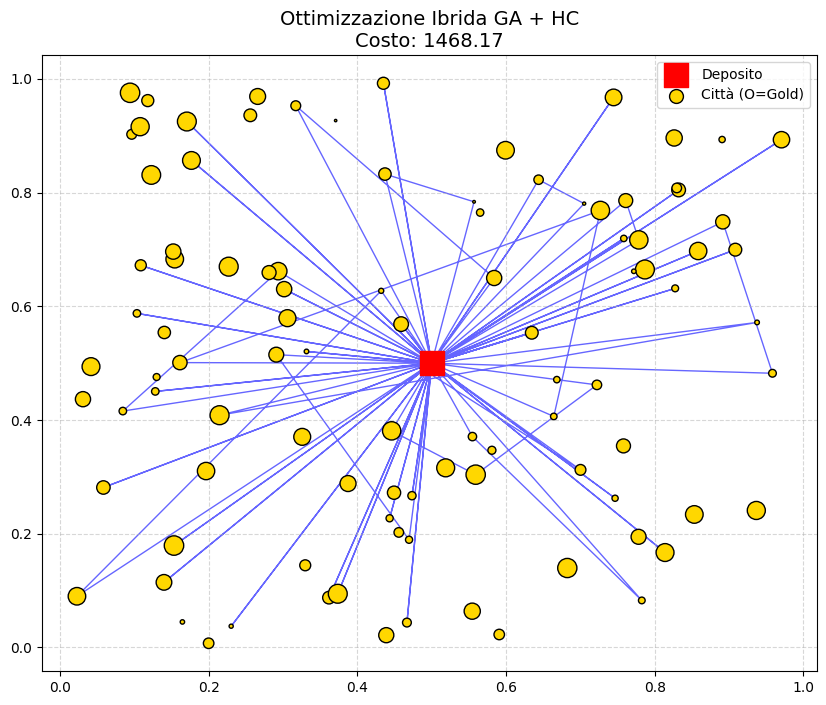

In [ ]:
import matplotlib.pyplot as plt

def plot_solution(problem, path, title="Soluzione Ottimizzata"):
    coords = nx.get_node_attributes(problem.graph, 'pos')
    gold = nx.get_node_attributes(problem.graph, 'gold')
    
    plt.figure(figsize=(10, 8))
    sizes = [gold[n]/5 for n in problem.graph.nodes if n != 0]
    plt.scatter(coords[0][0], coords[0][1], s=300, c='red', marker='s', label='Deposito', zorder=10)
    x_vals = [coords[n][0] for n in problem.graph.nodes if n != 0]
    y_vals = [coords[n][1] for n in problem.graph.nodes if n != 0]
    plt.scatter(x_vals, y_vals, s=sizes, c='gold', edgecolors='black', label='Città (O=Gold)', zorder=5)

    _, full_path_to_plot = evaluate_permutation_smart(problem, path, 
                                                      dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist')), 
                                                      nx.get_node_attributes(problem.graph, 'gold'))
    path_coords = [coords[n] for n in full_path_to_plot]
    path_x, path_y = zip(*path_coords)
    
    plt.plot(path_x, path_y, c='blue', alpha=0.6, linewidth=1, linestyle='-', zorder=1)
    plt.title(f"{title}\nCosto: {best_global_cost:.2f}", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_solution(p, refined_perm, title="Ottimizzazione Ibrida GA + HC")